# Daily time series

Data access example to plot the daily precipitation series

In [1]:
import xarray as xr

Open the virtual data set for daily (`day`) data interpolated to the regular lon-lat grid (CSAM-4i):

In [2]:
url = 'https://data.meteo.unican.es/thredds/dodsC/devel/issues/46/ncml/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/day/v20220727/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_day_v20220727'
ds = xr.open_dataset(url, chunks = dict(time = 100, lon = 100, lat = 100))
ds

<xarray.Dataset>
Dimensions:    (lon: 676, lat: 451, time: 1096, bnds: 2)
Coordinates:
  * lon        (lon) float64 -75.0 -74.96 -74.92 -74.88 ... -48.08 -48.04 -48.0
  * lat        (lat) float64 -35.0 -34.96 -34.92 -34.88 ... -17.08 -17.04 -17.0
  * time       (time) datetime64[ns] 2018-06-01T11:30:00 ... 2021-05-31T11:30:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(100, 2), meta=np.ndarray>
    hurs       (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    rsds       (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    sfcWind    (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    tasmin     (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                    CF-1.8
    history:                        Thu Jul 14 18:16:58 2022: cdo remap,desti...
    institution:                    Instituto de Fisica de Cantabria, CSIC-Un...
    creation_date:                  2022-07-13-T09:18:06Z
    experiment:                     Evaluation run with ECMWF ERA5 reanalysis...
    experiment_id:                  FPS-SESA
    ...                             ...
    comment:                        Simulation performed at CESGA (https://ww...
    CDO:                            Climate Data Operators version 1.9.8 (htt...
    CORDEX_domain:                  CSAM-4i
    contact:                        meteo@unican.es
    size:                           2147483647
    size_human:                     6.0 GiB

This loaded the full dataset (3 years and all variables) information into `ds`. Variables can be accessed as attributes of this object:

In [3]:
ds.pr

<xarray.DataArray 'pr' (time: 1096, lat: 451, lon: 676)>
dask.array<open_dataset-cbfe0a34cfe8605c412accd59b64c5d4pr, shape=(1096, 451, 676), dtype=float32, chunksize=(100, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -75.0 -74.96 -74.92 -74.88 ... -48.08 -48.04 -48.0
  * lat      (lat) float64 -35.0 -34.96 -34.92 -34.88 ... -17.08 -17.04 -17.0
  * time     (time) datetime64[ns] 2018-06-01T11:30:00 ... 2021-05-31T11:30:00
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitaion
    units:          kg m-2 s-1
    cell_methods:   time: mean
    _ChunkSizes:    [ 7 50 50]

This is how the common spatial domain looks like (this operation takes some time since some data needs to be retrieved):

CPU times: user 3.77 s, sys: 997 ms, total: 4.77 s
Wall time: 1min 13s


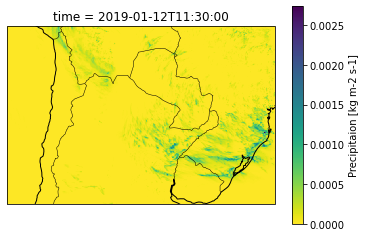

In [4]:
%%time

import cartopy.crs as ccrs
import cartopy.feature as cfea
from matplotlib import cm

p = ds.pr.sel({'time': '2019-01-12'}).plot(
    transform = ccrs.PlateCarree(),
    #subplot_kws = dict(projection=ccrs.Orthographic(-60, -20)),
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    cmap = cm.viridis_r
)
p.axes.add_feature(cfea.COASTLINE, linewidth=1)
p.axes.add_feature(cfea.BORDERS, linewidth=0.5)

## Extract a single time series

Near Porto Alegre

CPU times: user 1.25 s, sys: 351 ms, total: 1.61 s
Wall time: 27.6 s


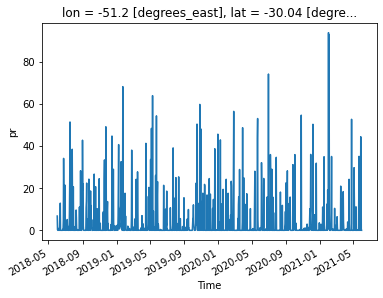

In [5]:
%%time

target_location = dict(lon=-51.22, lat=-30.04)
tseries = ds.pr.sel(target_location, method = 'nearest') * 86400 # daily flux to mm/day
tseries.plot()

Average monthly rainfall in mm/day:

CPU times: user 1.29 s, sys: 366 ms, total: 1.65 s
Wall time: 28.9 s


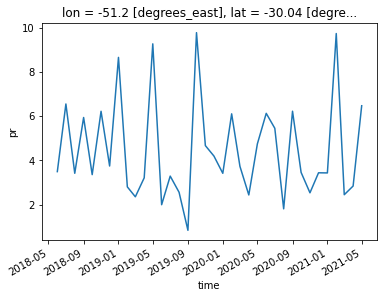

In [6]:
%%time

mtseries = tseries.resample(time = '1MS').mean(dim='time').compute()
mtseries.plot()

## Load observations

> _For the moment, loading independently each yearly file. TODO: prepare and load a virtual dataset aggregating time_

In [7]:
mswx_urls = [
  'https://data.meteo.unican.es/thredds/dodsC/devel/issues/46/raw/observations/CSAM-4i/GloH2O/MSWX/3hr/pr/pr_CSAM-4i_GloH2O-MSWX_3hr_201801010000-201831122100.nc',
  'https://data.meteo.unican.es/thredds/dodsC/devel/issues/46/raw/observations/CSAM-4i/GloH2O/MSWX/3hr/pr/pr_CSAM-4i_GloH2O-MSWX_3hr_201901010000-201931122100.nc',
  'https://data.meteo.unican.es/thredds/dodsC/devel/issues/46/raw/observations/CSAM-4i/GloH2O/MSWX/3hr/pr/pr_CSAM-4i_GloH2O-MSWX_3hr_202001010000-202031122100.nc',
  'https://data.meteo.unican.es/thredds/dodsC/devel/issues/46/raw/observations/CSAM-4i/GloH2O/MSWX/3hr/pr/pr_CSAM-4i_GloH2O-MSWX_3hr_202101010000-202131122100.nc',
]
obs = xr.open_mfdataset(mswx_urls, chunks = dict(time = 100, lon = 100, lat = 100))
obs

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'pr' has multiple fill values {1e+20, '1.e+20f'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'pr' has multiple fill values {1e+20, '1.e+20f'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'pr' has multiple fill values {1e+20, '1.e+20f'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'pr' has multiple fill values {1e+20, '1.e+20f'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


,Array,Chunk
Bytes,13.27 GiB,3.81 MiB
Shape,"(11688, 451, 676)","(100, 100, 100)"
Count,8404 Tasks,4200 Chunks
Type,float32,numpy.ndarray


In [8]:
%%time

obs_tseries = obs.pr.sel(target_location, method = 'nearest') * 86400 # 3h flux to mm/day
obs_mtseries = obs_tseries.resample(time = '1MS').mean(dim='time').compute()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


CPU times: user 11.7 s, sys: 3.74 s, total: 15.4 s
Wall time: 5min 15s


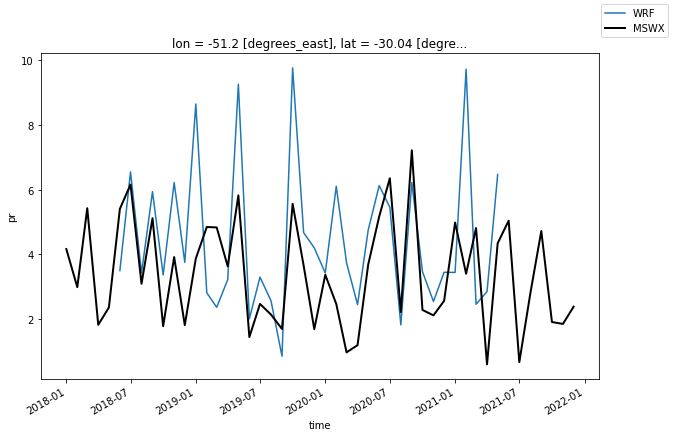

In [9]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10,6))
ax = f.gca()
mtseries.plot(ax = ax)
obs_mtseries.plot(ax = ax, color = 'k', linewidth = 2)
f.legend(['WRF', 'MSWX'])